# （2）手写数字图像的生成

## 1．准备数据
步骤 1 导入本项目所需要的模块与包。  
步骤 2 从 Keras 中导入 MNIST 数据集，将训练集的特征值和标签值分别存储在 x_train 和 y_train 中。  
步骤 3 选出训练集中标签值为 8 的图像，重构数据集，并随机选取部分图像进行显示。

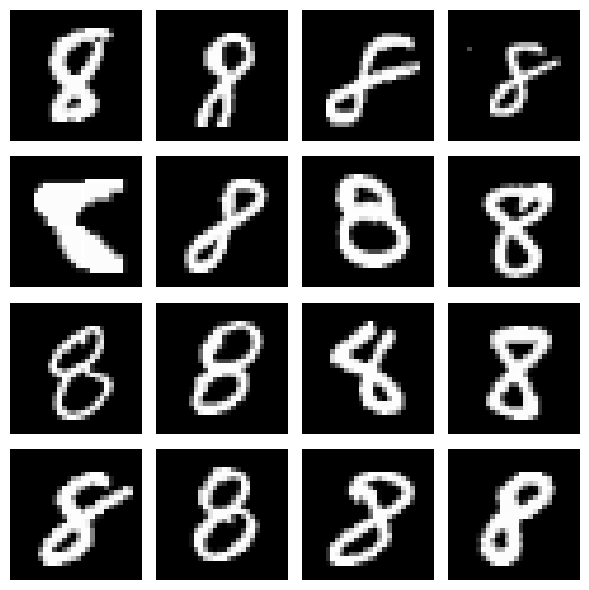

训练数据集样本数：5851
每个样本的形状：(28, 28, 1)
批量大小：256


In [1]:
# 导入所需要的模块与包
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from IPython import display

# 导入 MNIST 数据集
mnist = tf.keras.datasets.mnist
(x_train, y_train), (_, _) = mnist.load_data()

# 过滤出标签为 8 的数据，并显示部分图像
x_train = x_train[y_train == 8]  # 只选择标签为 8 的样本

# 随机显示 16 张图片
plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    t = np.random.randint(0, x_train.shape[0])  # 随机选择一个索引
    plt.axis("off")  # 隐藏坐标轴
    plt.imshow(x_train[t], cmap='gray')  # 显示灰度图
plt.tight_layout()
plt.show()

# 特征值标准化处理
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')  # 调整形状
x_train = (x_train - 127.5) / 127.5  # 标准化到 [-1, 1]

# 打乱数据并批量化
BUFFER_SIZE = 6000  # 缓冲区大小
BATCH_SIZE = 256  # 批量大小
train_dataset = tf.data.Dataset.from_tensor_slices(x_train) \
                                .shuffle(BUFFER_SIZE) \
                                .batch(BATCH_SIZE)

# 打印处理后的数据集信息
print(f"训练数据集样本数：{x_train.shape[0]}")
print(f"每个样本的形状：{x_train.shape[1:]}")
print(f"批量大小：{BATCH_SIZE}")


## 2．构建生成模型
生成模型包括一个全连接层、3 个批量标准化层、一个 Reshape 层和 3 个转置卷积层。  
步骤 1 定义生成模型函数。  
步骤 2 在函数中构建空的顺序网络模型。  
步骤 3 为网络模型添加全连接层，结点个数为 12 544（7×7× 256），不使用偏置向量，input_shape 为(100,0)，即输入噪声的大小，使用 LeakyReLU 函数作为激活函数；然后添加批量标准化层。

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

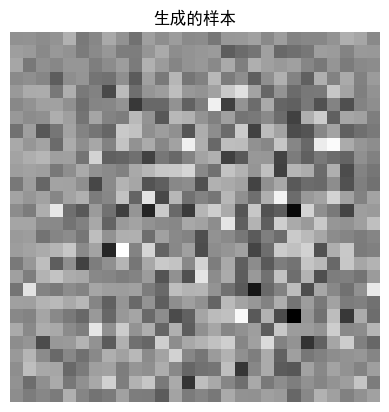

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置字体为 SimHei (你可以根据系统安装的字体选择其他支持中文的字体)
rcParams['font.family'] = 'SimHei'

# 如果遇到中文乱码的问题，可以强制显示中文
# rcParams['axes.unicode_minus'] = False  # 防止负号显示为方块
# 构建生成模型
def make_generator_model():
    # 创建一个顺序模型
    model = tf.keras.Sequential()

    # 添加全连接层和批量标准化层
    model.add(tf.keras.layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    # 添加 Reshape 层
    model.add(tf.keras.layers.Reshape((7, 7, 256)))

    # 添加第一个转置卷积层和批量标准化层
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    # 添加第二个转置卷积层和批量标准化层
    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    # 添加第三个转置卷积层
    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

# 创建生成模型对象
generator = make_generator_model()

# 显示生成模型的各层参数信息
generator.summary()

# 创建生成样本测试
noise = tf.random.normal([1, 100])  # 创建随机噪声，输入维度为 (1, 100)

# 调用生成模型生成样本
generated_image = generator(noise, training=False)

# 显示生成的样本
plt.imshow(generated_image[0, :, :, 0], cmap='gray')  # 显示灰度图
plt.title("生成的样本")
plt.axis("off")  # 隐藏坐标轴
plt.show()


## 3．构建判别模型
判别模型包括两个卷积层、两个 Dropout 层、一个拉伸层和一个输出层。  
步骤 1 定义判别模型函数。  
步骤 2 在函数中构建空的顺序网络模型。  
步骤 3 为网络模型添加卷积层，输出通道数为 64，卷积核大小为 5×5，步长为(2,2)，填充方式为
'SAME'，input_shape 为(28,28,1)，使用 LeakyReLU 函数作为激活函数；然后添加 Dropout 层，丢弃概率为
0.3。

In [3]:
import tensorflow as tf

# 构建判别模型
def make_discriminator_model():
    """
    构建判别模型的函数。
    :return: 判别模型
    """
    model = tf.keras.Sequential()  # 创建一个空的顺序模型

    # 添加第一组卷积层、LeakyReLU激活层和Dropout层
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    # 添加第二组卷积层、LeakyReLU激活层和Dropout层
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    # 添加 Flatten 层，将卷积层的输出展平
    model.add(tf.keras.layers.Flatten())

    # 添加输出层
    model.add(tf.keras.layers.Dense(1))  # 输出层：判别结果（真实为1，生成为0）

    return model

# 创建判别模型对象
discriminator = make_discriminator_model()

# 显示判别模型的各层参数信息
discriminator.summary()

# 假设生成图像已经生成（从生成器获得）
# 这里假设 generated_image 是从生成器模型输出的图像
generated_image = tf.random.normal([1, 28, 28, 1])  # 随机生成一个假图像，作为测试

# 使用判别模型对生成的图像进行判别
decision = discriminator(generated_image)

# 打印判别结果
print(decision)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

## 4．定义损失函数和优化器
步骤 1 定义二元交叉熵损失函数对象 cross_entropy。  
步骤 2 定义判别模型的损失函数，首先计算真实样本与同维度像素全 1 张量的二元交叉熵损失函数值；然后计算生成样本与同维度像素全 0 张量的二元交叉熵损失函数值；最后将两部分的损失函数值相加  作为判别模型损失函数的返回值。  
步骤 3 定义生成模型的损失函数，计算生成样本与同维度像素全 1 张量的损失函数值，然后将其作为生成模型损失函数的返回值。

In [4]:
# 定义损失函数和优化器
# 使用二元交叉熵作为损失函数
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 定义判别模型的损失函数
def discriminator_loss(real_output, fake_output):
    """
    计算判别器的损失，包括真实样本和生成样本的损失之和。
    :param real_output: 判别器对真实样本的预测输出
    :param fake_output: 判别器对生成样本的预测输出
    :return: 判别器的总损失
    """
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # 真实样本的损失
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # 生成样本的损失
    total_loss = real_loss + fake_loss  # 总损失
    return total_loss

# 定义生成模型的损失函数
def generator_loss(fake_output):
    """
    计算生成器的损失，使生成样本尽可能被判别器识别为真实样本。
    :param fake_output: 判别器对生成样本的预测输出
    :return: 生成器的损失
    """
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# 定义生成模型的优化器
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 定义判别模型的优化器
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


## 5．定义检查点
对于训练时间较长、计算量较大的项目，在训练过程中，保存阶段性的权重和偏置等参数，可以在训练中途被中断后用来恢复网络模型。  
步骤 1 定义检查点文件路径，包括检查点文件存放位置和文件名。  
步骤 2 使用 tf.train.Checkpoint 类的构造函数创建检查点对象 checkpoint，参数为需要保存的对象，此处设置为生成模型的优化器、判别模型的优化器、生成模型对象和判别模型对象。

In [5]:
import os
import tensorflow as tf

# 定义检查点存放位置
checkpoint_dir = './checkpoints'  # 检查点目录
os.makedirs(checkpoint_dir, exist_ok=True)  # 确保目录存在

# 定义检查点的文件名前缀
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# 定义检查点对象
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,  # 生成器优化器
    discriminator_optimizer=discriminator_optimizer,  # 判别器优化器
    generator=generator,  # 生成器模型
    discriminator=discriminator  # 判别器模型
)


## 6．训练模型
步骤 1 定义训练模型的参数，包括训练次数、输入噪声的长度、生成样本的数量和输入向量。  
步骤 2 定义单次训练模型函数 train_step()，输入参数为真实样本。① 使用随机函数生成输入噪声；② 使用 with 结构记录梯度信息，首先使用生成模型基于输入噪声创建生成样本，然后分别使用判别模型对真实样本和生成样本进行判别，最后分别计算生成模型和判别模型的损失函数值；③ 计算生成模型和判别模型的梯度；④ 更新生成模型和判别模型的可训练参数。  
步骤 3 定义生成、显示和保存生成样本图像函数 generate_and_save_images()。① 调用函数产生生成样本图像；② 创建子图，在子图中绘制生成样本图像；③ 将生成样本保存到图像文件中。

<Figure size 640x480 with 0 Axes>

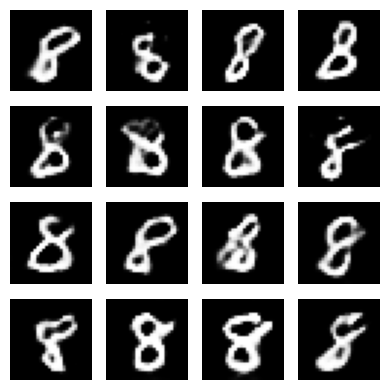

第 500 次训练花费 6.21 秒


<Figure size 640x480 with 0 Axes>

In [6]:
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display

# 定义训练模型的参数
EPOCHS = 500  # 训练轮数
noise_dim = 100  # 输入噪声的维度
num_examples_to_generate = 16  # 生成样本的数量

# 产生随机种子作为固定输入向量，用于观察生成器效果变化
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# 定义单次训练模型的函数
def train_step(images):
    """
    执行一次训练步骤，包括生成器和判别器的梯度更新。
    :param images: 当前批次的真实样本图像
    """
    # 使用随机函数生成输入噪声
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # 记录生成器和判别器的梯度
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 使用生成器生成样本
        generated_images = generator(noise, training=True)

        # 判别器对真实样本的预测
        real_output = discriminator(images, training=True)

        # 判别器对生成样本的预测
        fake_output = discriminator(generated_images, training=True)

        # 计算生成器和判别器的损失值
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # 计算生成器和判别器的梯度
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 应用梯度更新生成器和判别器的参数
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# 生成、显示和保存生成样本图像
def generate_and_save_images(model, epoch, test_input):
    """
    生成样本图像，并保存到本地。
    :param model: 生成器模型
    :param epoch: 当前训练轮数
    :param test_input: 用于生成样本的随机输入
    """
    # 生成样本
    predictions = model(test_input, training=False)

    # 显示生成样本
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')  # 恢复像素值到 [0, 255]
        plt.axis('off')

    # 显示图像
    plt.tight_layout()
    plt.show()

    # 保存生成样本
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')

# 定义完整训练模型的函数
def train(dataset, epochs):
    """
    完整的训练流程，包括模型的多轮训练、生成样本图像、保存检查点等。
    :param dataset: 训练数据集
    :param epochs: 训练轮数
    """
    for epoch in range(epochs):
        start = time.time()  # 记录训练开始时间

        # 按批次训练模型
        for image_batch in dataset:
            train_step(image_batch)

        # 每轮训练后生成并显示样本
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # 每训练 10 次保存一次检查点
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # 打印当前训练轮所用时间
        print(f'第 {epoch + 1} 次训练花费 {time.time() - start:.2f} 秒')

# 调用 train() 函数完成模型训练
train(train_dataset, EPOCHS)
